In [5]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as preprocessing
le= preprocessing.LabelEncoder()
import os

#download
import urllib.request as req
import zipfile
import io


In [6]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Downloading

In [7]:
#retrieving data

import wget
datasets='/Volumes/Datasets'
project='school_shootings'
url='https://github.com/ecodan/school-shooting-data/archive/refs/heads/master.zip'

zfile=os.path.join(datasets,project,url.split('/')[-1] )
print(zfile)
if not os.path.exists(zfile):
    command=('').join(['-P ', os.path.join(datasets, project),' ', url] )
    print(command)
    !wget $command
else:
    print('file exists')

/Volumes/Datasets/school_shootings/master.zip
file exists


In [8]:
print(os.path.join(datasets,project))

/Volumes/Datasets/school_shootings


In [9]:
#unzipping
files_to_extract=['cps_01_formatted.csv', 'pah_wikp_combo.csv']
data_folder=os.path.join(datasets,project,'school-shooting-data-master')

#extract files if they don't exist
for f in files_to_extract:
    if not os.path.exists(os.path.join(data_folder,f)):
        with zipfile.ZipFile(zfile, 'r') as z:
            print(z.namelist())
            z.extract(os.path.join('school-shooting-data-master',f), os.path.join(datasets,project))
    else:
        print(f, 'already exists in folder')


cps_01_formatted.csv already exists in folder
pah_wikp_combo.csv already exists in folder


In [10]:
#loading data into dataframes

def read_csv_into_dataframes(folder):
    '''
    functions converts .csv files into dataframes and assigns file name as the 'name' attribute for each dataframe that can later be retrieved using df.attrs['name'].

    :param folder: a path to .cvs files
    :returns: message with names of dataframes loaded
    '''
    dataframes=[]
    print('the following dataframes were read:','\n')
    for f in os.listdir(folder):
        vars()[f[:-4]]=pd.read_csv(os.path.join(folder,f))
        vars()[f[:-4]].attrs['name']=str(f[:-4]) #assigns name of file as name of df to be retrieved later
        print(vars()[f[:-4]].attrs['name'])
        dataframes.append(vars()[f[:-4]])
    return dataframes

In [11]:
dataframes=read_csv_into_dataframes(data_folder)

raw_data_2=dataframes[0]
raw_data_1=dataframes[1]

print('\n\n', raw_data_1.head(3), '\n\n--------------\n\n',raw_data_2.head(3))

the following dataframes were read: 

cps_01_formatted
pah_wikp_combo


         Date         City      State  AreaType School  Fatalities  Wounded  \
0  3/27/1990     Brooklyn   New York       NaN      C           0      1.0   
1  5/20/1990  Centerville  Tennessee  suburban     HS           1      NaN   
2  8/26/1990    Las Vegas     Nevada     urban     HS           1      NaN   

  Dupe Source                                               Desc  Unnamed: 10  \
0  NaN   Wikp  A black youth was taunted with racial slurs by...          NaN   
1  NaN    Pah                                                NaN          NaN   
2  NaN    Pah                                                NaN          NaN   

   Unnamed: 11  
0          NaN  
1          NaN  
2          NaN   

--------------

    Year  Total enrolled  N-Total  N-Public  N-Private  K-Total  K-Public  \
0  2022           72346   3405.0    1888.0     1517.0     3696      3009   
1  2021           73456   3801.0    2134.0     166

# Exploring

In [12]:
raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         809 non-null    object 
 1   City         809 non-null    object 
 2   State        809 non-null    object 
 3   AreaType     381 non-null    object 
 4   School       807 non-null    object 
 5   Fatalities   809 non-null    int64  
 6   Wounded      428 non-null    float64
 7   Dupe         138 non-null    object 
 8   Source       809 non-null    object 
 9   Desc         426 non-null    object 
 10  Unnamed: 10  0 non-null      float64
 11  Unnamed: 11  0 non-null      float64
dtypes: float64(3), int64(1), object(8)
memory usage: 76.0+ KB


#Cleaning

In [13]:
df=raw_data_1.copy()

In [14]:
#colum_names
def clean_column_names(df):
    '''
    function to call on after DataFrame is created to format column names in lowercase 
    without spaces before querying.
    
    :param query: DataFrame
    :returns: DataFrame with columns formatted  
    '''
    import pandas as pd 
    
    columns=df.columns
    new_names=[]
    char_dict={' ':'_',':':''}
    for c in columns:
        new_names.append(c
            .lower()
            .translate(char_dict)
          )
    df.columns=new_names

    return df

df=clean_column_names(df)
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         809 non-null    object 
 1   city         809 non-null    object 
 2   state        809 non-null    object 
 3   areatype     381 non-null    object 
 4   school       807 non-null    object 
 5   fatalities   809 non-null    int64  
 6   wounded      428 non-null    float64
 7   dupe         138 non-null    object 
 8   source       809 non-null    object 
 9   desc         426 non-null    object 
 10  unnamed: 10  0 non-null      float64
 11  unnamed: 11  0 non-null      float64
dtypes: float64(3), int64(1), object(8)
memory usage: 76.0+ KB


In [15]:
#date to timestamp
df.date=pd.to_datetime(df.date)

In [16]:
#school: delete '-" value
df.school=df.school.replace({'-':np.nan})

In [17]:
#state
value_dict={'District Of Columbia':'D.C.', 'District of Columbia':'D.C.', 'IA':'Iowa'}
df.state=df.state.replace(value_dict)

In [18]:
#add calculations
df=(df
  .assign(year=df.date.dt.year, month=df.date.dt.month)
  .assign(decade=((df.date.dt.year // 10) * 10))
)
df

,date,city,state,areatype,school,fatalities,wounded,dupe,source,desc,unnamed: 10,unnamed: 11,year,month,decade
0,1990-03-27,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN,1990,3,1990
1,1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN,1990,5,1990
2,1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN,1990,8,1990
3,1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN,1990,9,1990
4,1991-01-08,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN,1991,1,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,2023-08-25,Choctaw,Oklahoma,NaN,HS,1,4.0,NaN,Wikp,A 16-year-old Midwest City High School student...,NaN,NaN,2023,8,2020
805,2023-08-25,Greensboro,North Carolina,NaN,C,0,1.0,NaN,Wikp,A non-student was shot on the campus of North ...,NaN,NaN,2023,8,2020
806,2023-08-28,Chapel Hill,North Carolina,NaN,C,1,0.0,NaN,Wikp,Shooting of Zijie Yan: A graduate student shot...,NaN,NaN,2023,8,2020
807,2023-09-12,Greensburg,Louisiana,NaN,C,1,2.0,NaN,Wikp,Three people were shot at the St. Helena Colle...,NaN,NaN,2023,9,2020


# Styling

In [19]:
# Color blind friendly colors

# Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

style.use('fivethirtyeight')
# sns.axes_style({
#     'axes.facecolor': 'white',
#     'axes.edgecolor': 'black',
#     'axes.grid': False,
#     'figure.facecolor': 'white',
#     'grid.color': 'white',
#     'grid.linestyle': '-',
#     'font.sans-serif': 'Arial',
#     'grid.color': '#ffffff'

# })

footer_left="AAAS24 GIthub -  School Schootings" 
footer_right="Source: Pah/Amaral/Hagan Research & Wikipedia"

#Homework

## Incidents per Year

In [20]:



x_var='rol_decade'
bins=list(range(df.year.max()-30,df.year.max()+1,10))
print(bins)
data=(
  df.copy()
  .assign(rol_decade=pd.cut(x=df.year,bins=bins, labels=[ '1992-2001', '2002-2011','2012-2022']))
  .groupby([x_var])
  .agg({'date': "count", 'fatalities':"sum", "wounded":"sum" } )
  .assign(total_victims= lambda _df: _df.wounded + _df.fatalities)
  .rename(columns={"date":"count_shootings"})
  .drop(['fatalities', 'wounded'], axis=1)
  .reset_index()
)
data 

[1993, 2003, 2013, 2023]


,rol_decade,count_shootings,total_victims
0,1992-2001,199,397.0
1,2002-2011,283,525.0
2,2012-2022,247,641.0


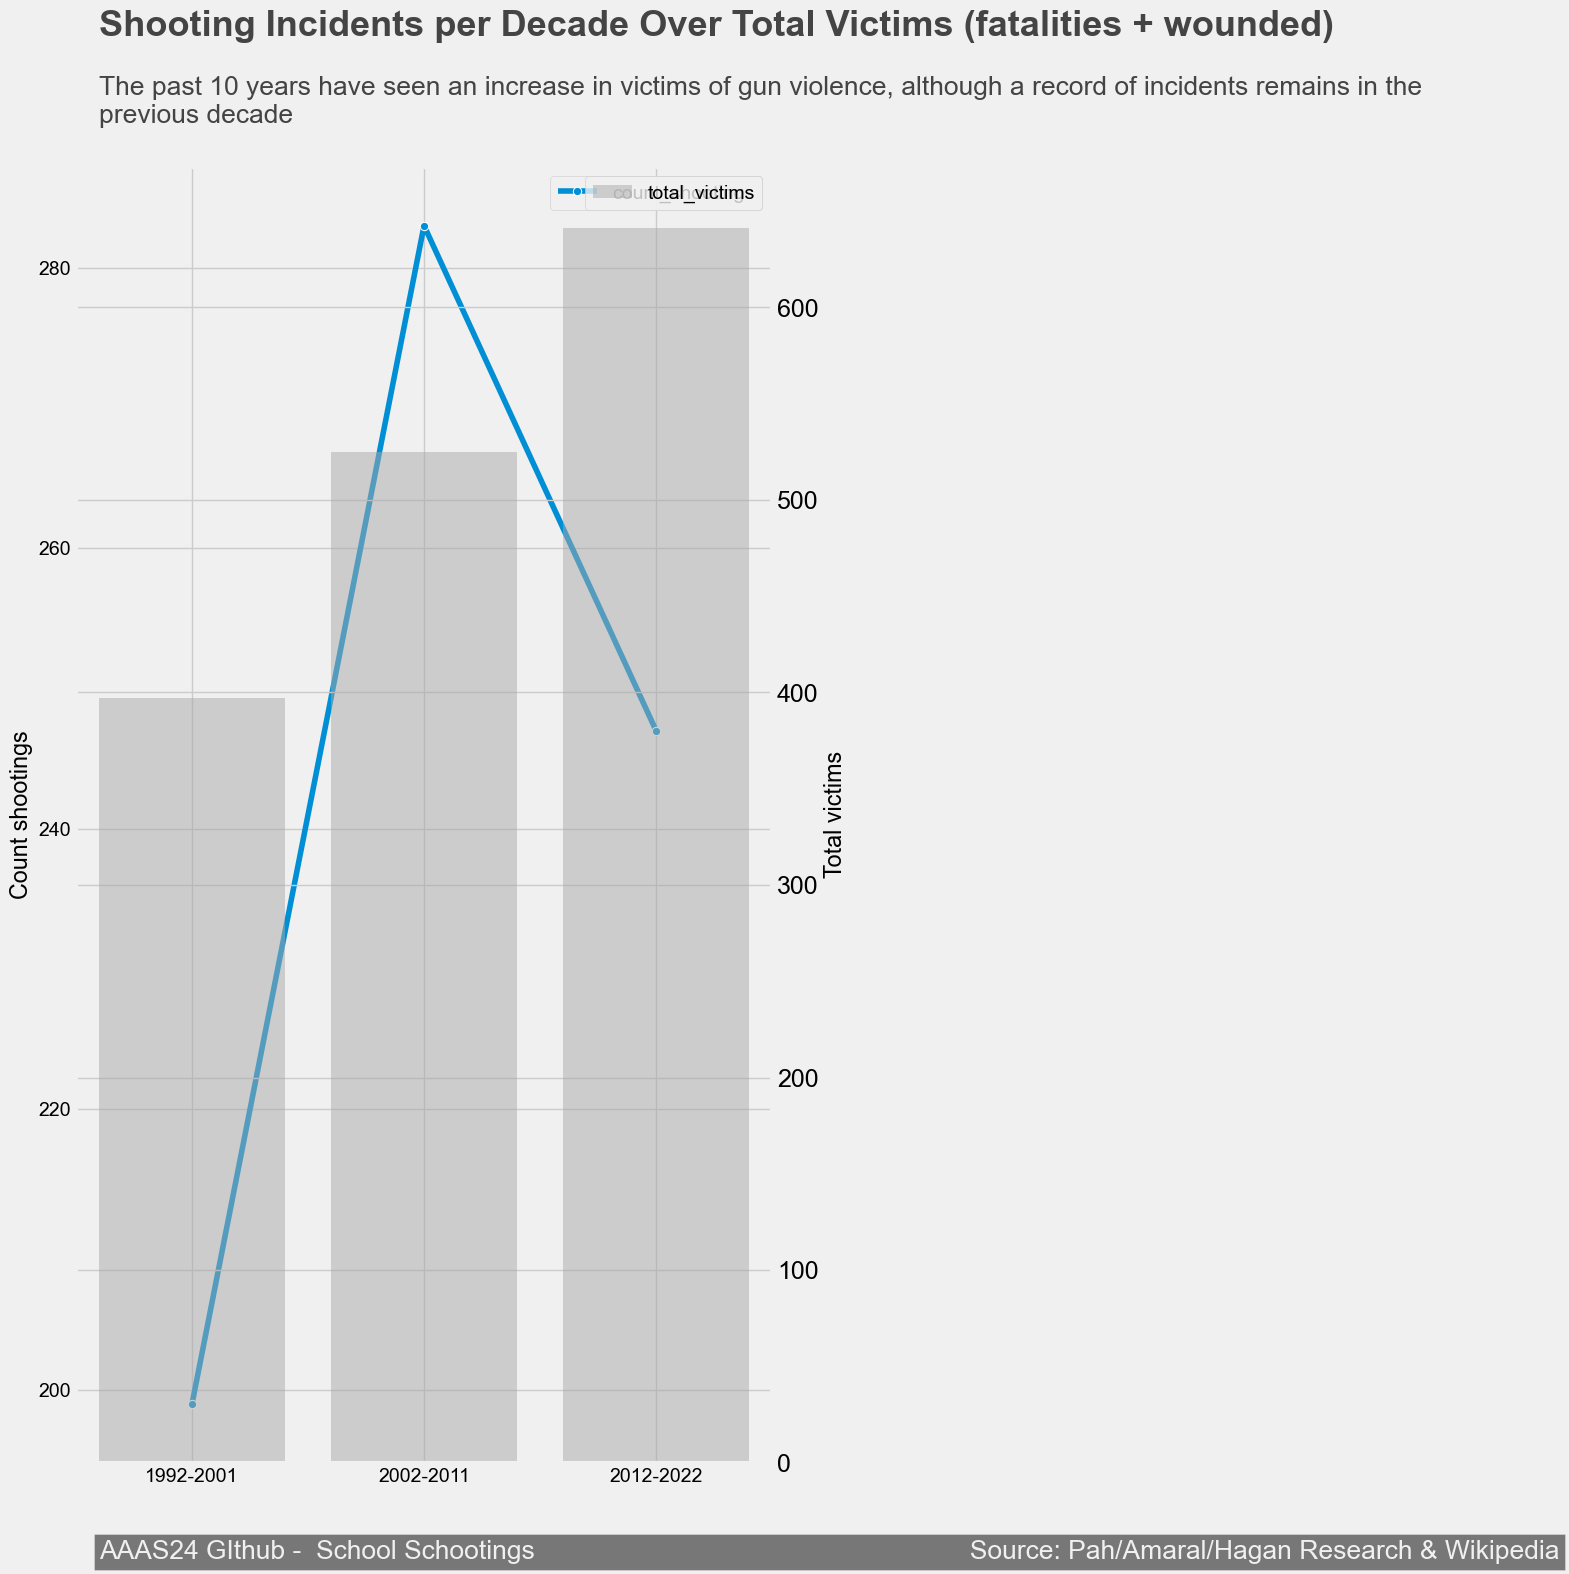

In [21]:
#incidents per year
title='Shooting Incidents per Decade Over Total Victims (fatalities + wounded)'
subtitle='The past 10 years have seen an increase in victims of gun violence, although a record of incidents remains in the \nprevious decade'
x_var='rol_decade'
num_blank=30 #modify to make footer fit 

#data


data=(
  df.copy()
  .assign(rol_decade=pd.cut(x=df.year,bins=bins, labels=[ '1992-2001', '2002-2011','2012-2022']))
  .groupby([x_var])
  .agg({'date': "count", 'fatalities':"sum", "wounded":"sum" } )
  .assign(total_victims= lambda _df: _df.wounded + _df.fatalities)
  .rename(columns={"date":"count_shootings"})
  .drop(['fatalities', 'wounded'], axis=1)
  .reset_index()
)
data 

#
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,16))

##1st chart
y_var='count_shootings'
sns.lineplot(data = data.count_shootings, marker='o', sort = False, ax=ax1, label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())
ax2 = ax1.twinx()

##2nd chart
y_var='total_victims'
sns.barplot(data = data, x=x_var, y=y_var, alpha=0.5, ax=ax2, color='#a9a9a9', label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())

##labels 
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')

##leyend
plt.legend(labelspacing=  2)

sns.set(rc={"figure.figsize":(8 ,16)})

##styling
style.use('fivethirtyeight')

#hiding x label
a=plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)

###Title & Subtitle
plt.text(x=-0.4, y=data[y_var].max()+100, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-0.4, y=data[y_var].max()+55, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
plt.tick_params(axis='both', which='major', labelsize=18)

num_spaces=" ".join(" "*int(num_blank))
plt.text(x=-0.4, y=-50, 
              s=footer_left+num_spaces+footer_right,
              fontsize=19,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()



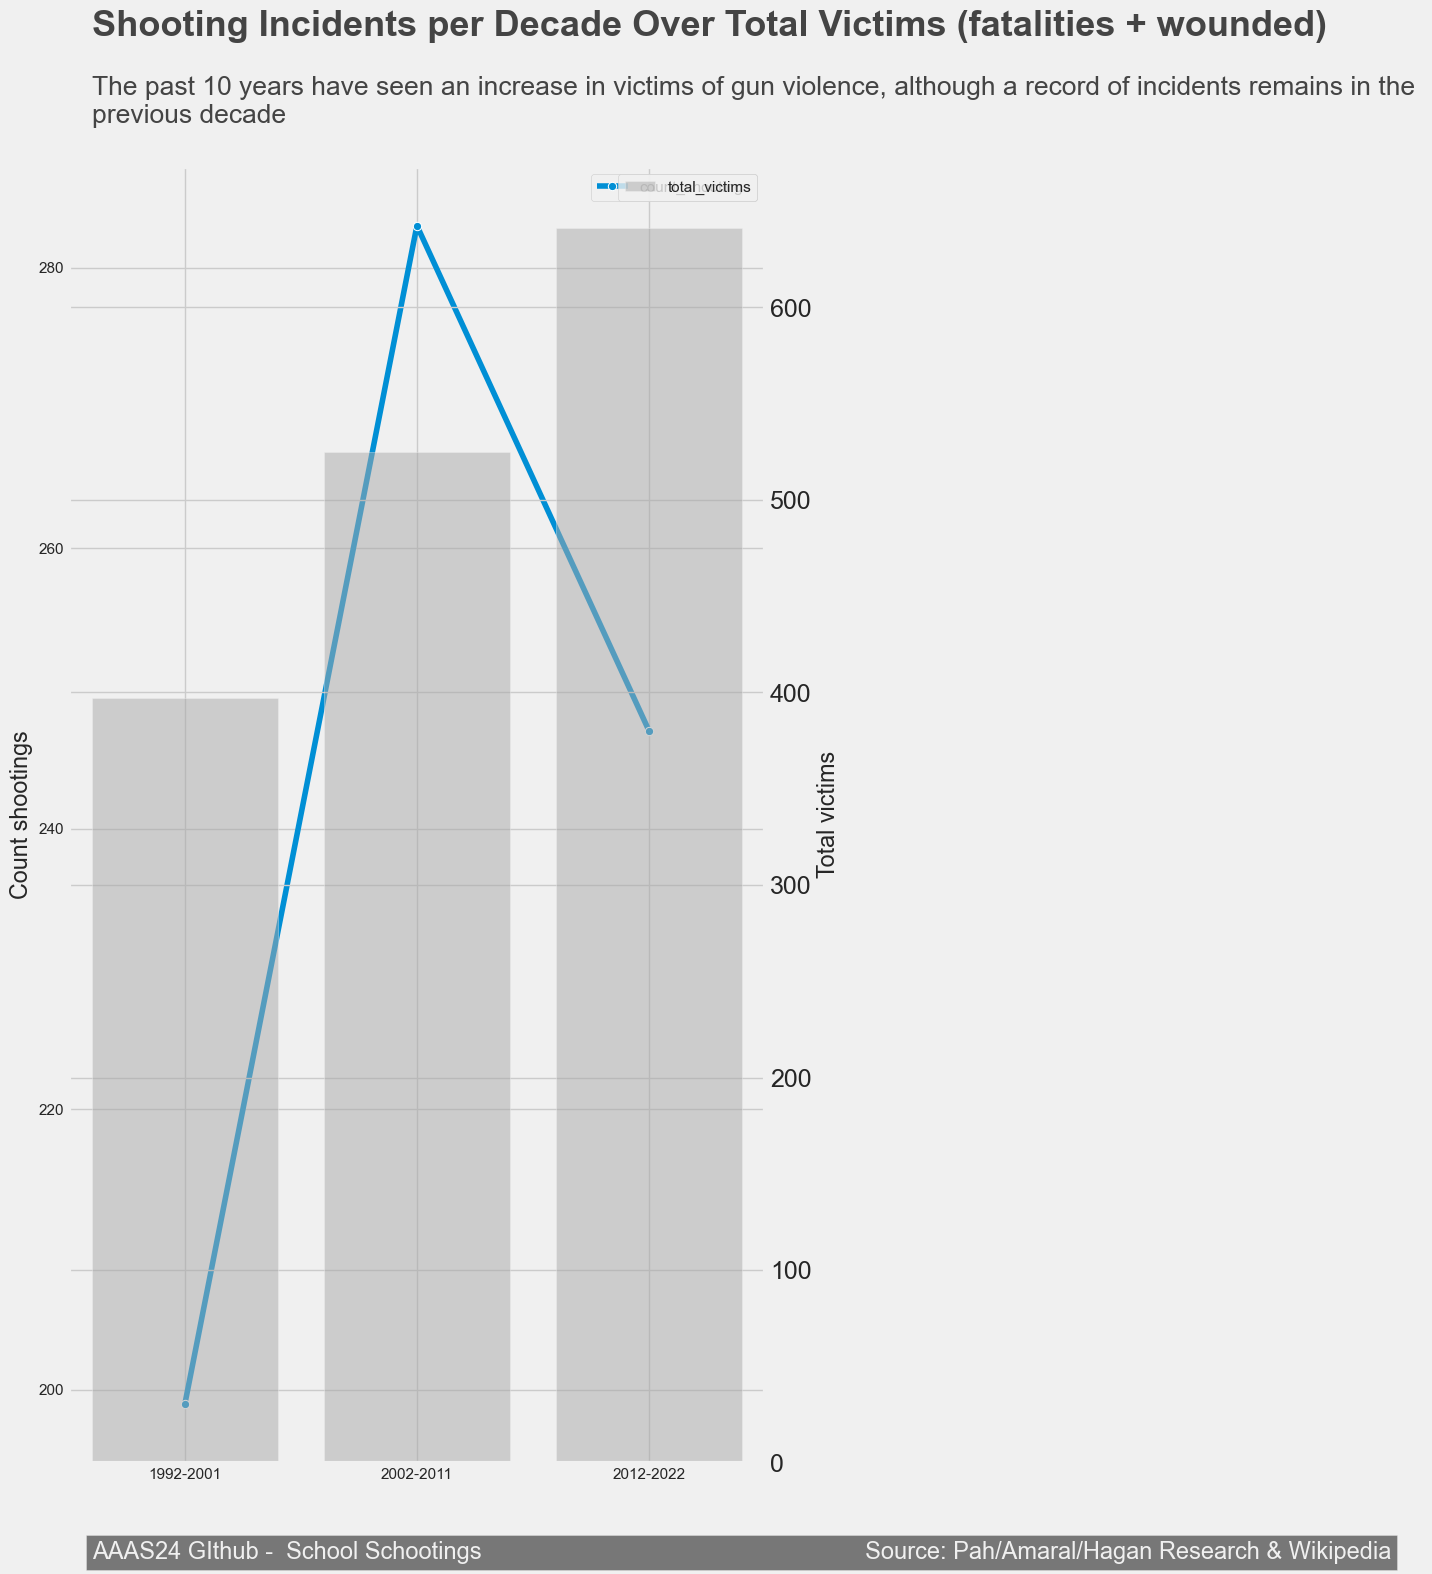

In [22]:
#incidents per year
title='Shooting Incidents per Decade Over Total Victims (fatalities + wounded)'
subtitle='The past 10 years have seen an increase in victims of gun violence, although a record of incidents remains in the \nprevious decade'
x_var='rol_decade'
num_blank=30 #modify to make footer fit 

#data

bins=list(range(df.year.max()-30,df.year.max()+1,10))
data=(
  df.copy()
  .assign(rol_decade=pd.cut(x=df.year,bins=bins, labels=[ '1992-2001', '2002-2011','2012-2022']))
  .groupby([x_var])
  .agg({'date': "count", 'fatalities':"sum", "wounded":"sum" } )
  .assign(total_victims= lambda _df: _df.wounded + _df.fatalities)
  .rename(columns={"date":"count_shootings"})
  .drop(['fatalities', 'wounded'], axis=1)
  .reset_index()
)
data 

#
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,16))

##1st chart
y_var='count_shootings'
sns.lineplot(data = data.count_shootings, marker='o', sort = False, ax=ax1, label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())
ax2 = ax1.twinx()

##2nd chart
y_var='total_victims'
sns.barplot(data = data, x=x_var, y=y_var, alpha=0.5, ax=ax2, color='#a9a9a9', label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())

##labels 
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')

##leyend
plt.legend(labelspacing=  2)

sns.set(rc={"figure.figsize":(8 ,16)})

##styling
style.use('fivethirtyeight')

#hiding x label
a=plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)

###Title & Subtitle
plt.text(x=-0.4, y=data[y_var].max()+100, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-0.4, y=data[y_var].max()+55, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
plt.tick_params(axis='both', which='major', labelsize=18)

num_spaces=" ".join(" "*int(num_blank))
plt.text(x=-0.4, y=-50, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()



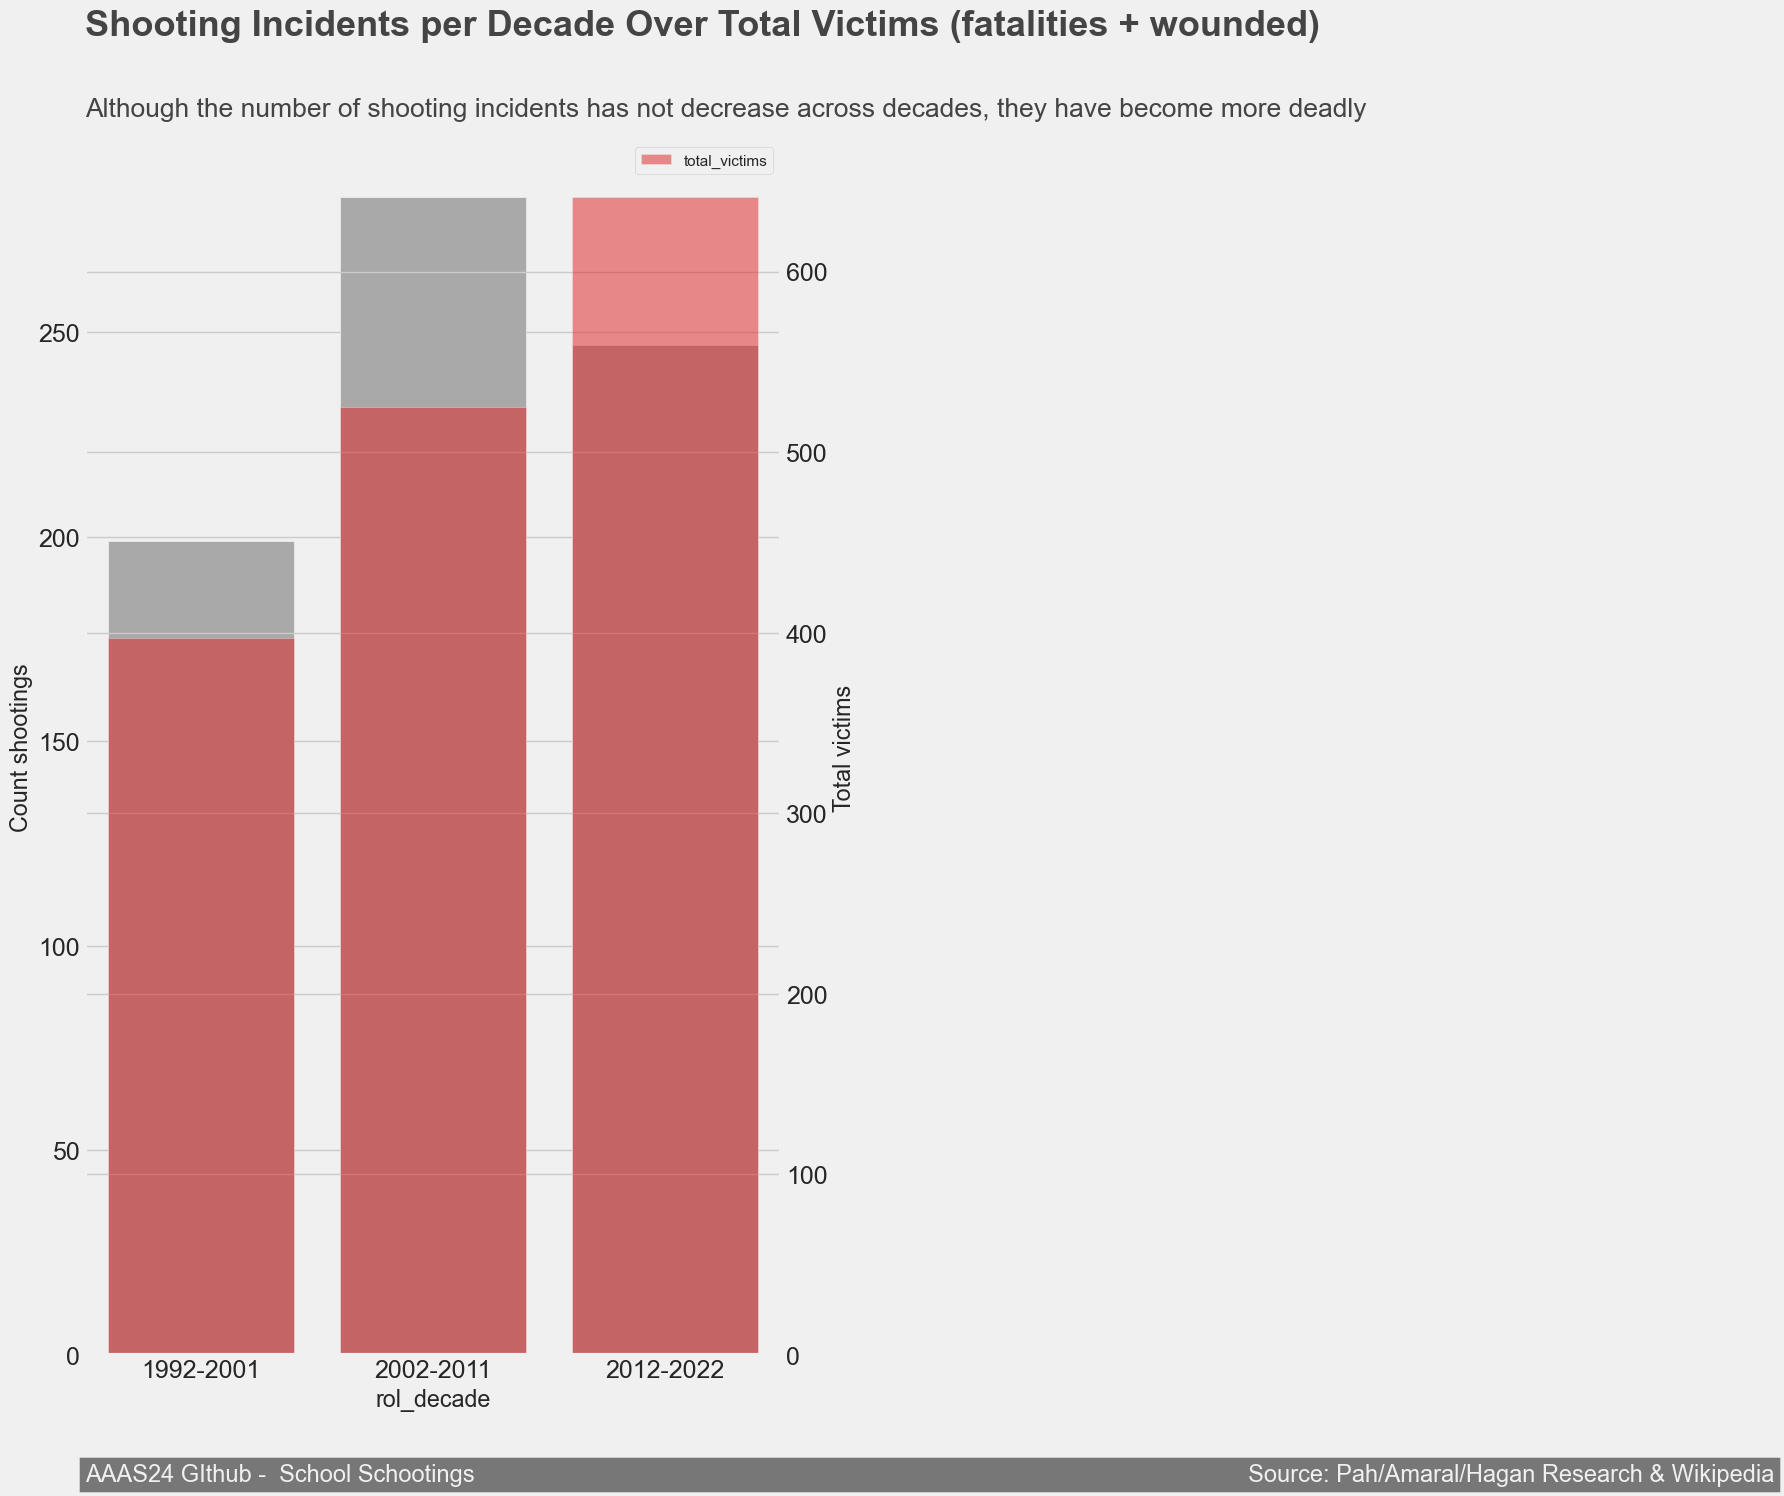

In [23]:
#incidents per year
title='Shooting Incidents per Decade Over Total Victims (fatalities + wounded)'
subtitle='Although the number of shooting incidents has not decrease across decades, they have become more deadly'
x_var='rol_decade'
text_x=60 #modify to make footer fit 

#data

bins=list(range(df.year.max()-30,df.year.max()+1,10))
data=(
  df.copy()
  .assign(rol_decade=pd.cut(x=df.year,bins=bins, labels=[ '1992-2001', '2002-2011','2012-2022']))
  .groupby([x_var])
  .agg({'date': "count", 'fatalities':"sum", "wounded":"sum" } )
  .assign(total_victims= lambda _df: _df.wounded + _df.fatalities)
  .rename(columns={"date":"count_shootings"})
  .drop(['fatalities', 'wounded'], axis=1)
  .reset_index()
)
data



ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,15))

##1st chart
y_var='count_shootings'
sns.barplot(data = data.loc[:,['rol_decade','count_shootings']], x=x_var, y=y_var, alpha=1, ax=ax1, color='#a9a9a9', label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())
plt.tick_params(axis='both', which='major', labelsize=18)
ax2 = ax1.twinx()

##2nd chart
y_var='total_victims'
sns.barplot(data = data.loc[:,['rol_decade','total_victims']], x=x_var, y=y_var, alpha=0.5, ax=ax2, color='red', label=y_var)
plt.ylabel(y_var.replace("_"," ").capitalize())
plt.tick_params(axis='both', which='major', labelsize=18)

##labels 
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')
#hiding x label
a=plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)

##leyend
plt.legend(labelspacing=  2)

##styling
style.use('fivethirtyeight')
sns.set_style("white")

###Title & Subtitle
plt.text(x=-0.5, y=data[y_var].max()+90, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-0.5, y=data[y_var].max()+45, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
width_ticks=(text_x)
num_spaces=" ".join(" "*int(text_x))
plt.text(x=-0.5, y=-70, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()


##Evaluating seasonality patterns

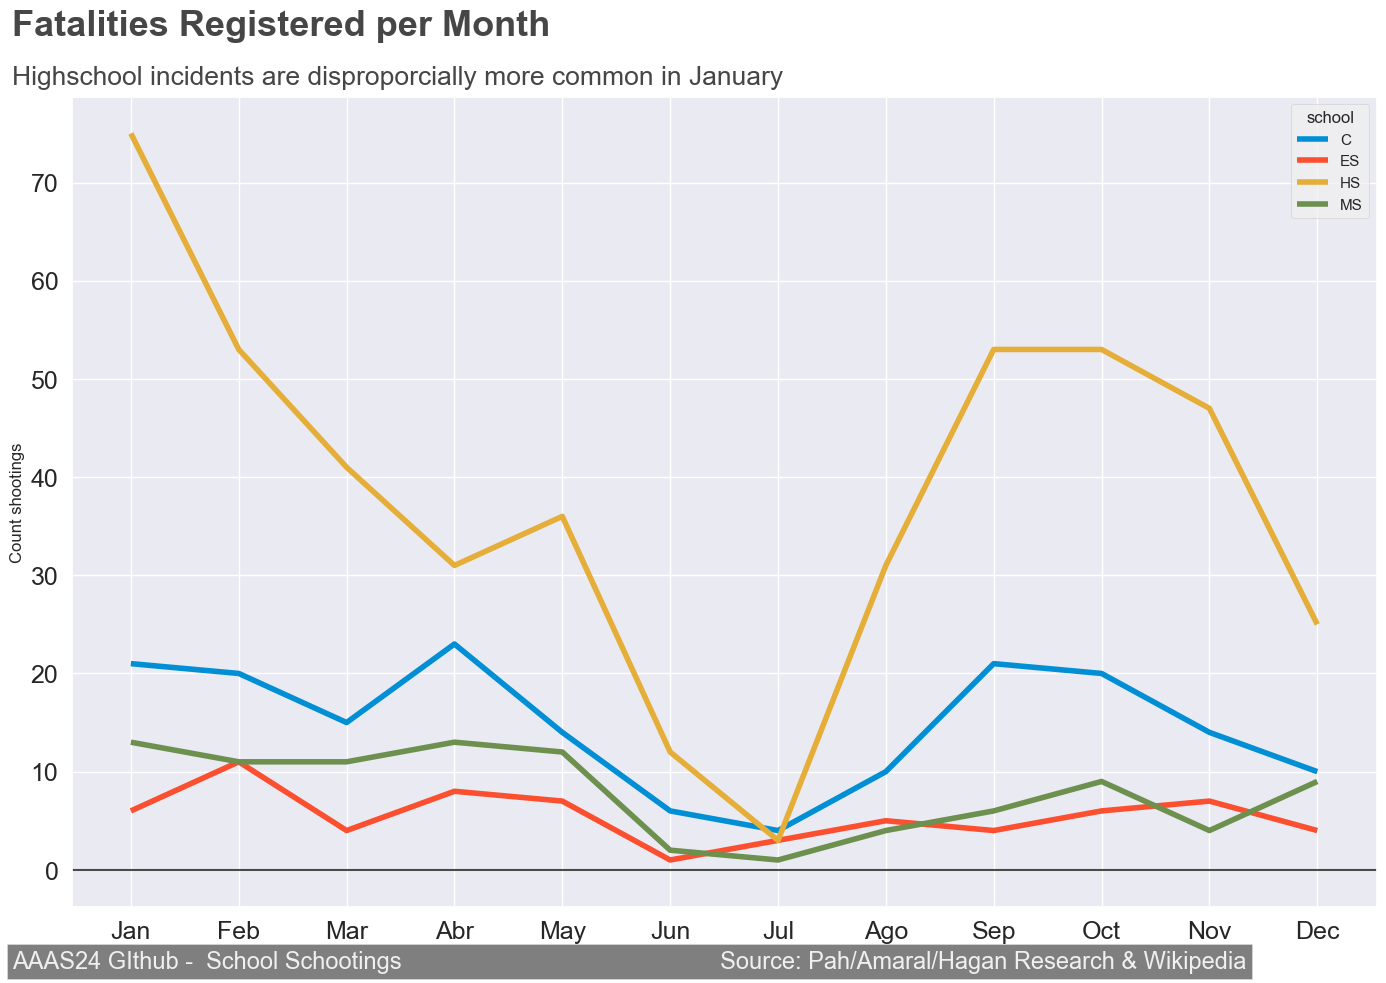

In [24]:
#fatalities per months
title='Fatalities Registered per Month'
subtitle='Highschool incidents are disproporcially more common in January'
x_var='month'
y_var='count_shootings'
text_x=25

#data
data=(
  df.copy()
  .groupby(['month', 'school'])
  .agg({'date': "count"} )
  .rename(columns={"date":"count_shootings"})
  .reset_index()
)
data 

#plot
##styling
sns.set(rc={"figure.figsize":(15 ,10)}) #(width,height)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')
style.use('fivethirtyeight')
# sns.set_style("white")

##plot
ax=sns.lineplot(data=data, x=x_var, y=y_var, hue='school')


##labels 
plt.ylabel(y_var.replace("_"," ").capitalize())
plt.xticks(np.arange(1, 13, step=1),['Jan', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'] )
#hiding x label
ax.set(xlabel=None)



x=0.1
###Title & Subtitle
plt.text(x=-x, y=data[y_var].max()+10, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-x, y=data[y_var].max()+5, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
width_ticks=(text_x)
num_spaces=" ".join(" "*int(text_x))
plt.text(x=-x, y=-10, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()

## Incidents per decade per school type

##### Incidents per decades
title='Fatalities per Decades'
subtitle='In the two years within the 2020s, we have past the 25% of previous decades, projecting this decade \nto follow or surpass previous ones'
x_var='decade'
y_var='count_shootings'
text_x=20

#data
data=(
  df.copy()
  .groupby([x_var])
  .agg({'date': "count"} )
  .rename(columns={"date":"count_shootings"})
  .reset_index()
)
data 

#plot
sns.set_style("white")
sns.barplot(data=data, x=x_var, y=y_var, color='grey', alpha=0.5)
plt.ylabel(y_var.replace("_"," ").capitalize())
#hiding x label
a=plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)

##style
sns.set(rc={"figure.figsize":(15 ,10)}) #(width,height)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')
style.use('fivethirtyeight')

x=0.5
###Title & Subtitle
plt.text(x=-x, y=data[y_var].max()+45, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )

plt.text(x=-x, y=data[y_var].max()+25, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

###Footnote Box
width_ticks=(text_x)
num_spaces=" ".join(" "*int(text_x))
plt.text(x=-x, y=-30, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17,
              color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )



plt.show()

In [25]:
#Idea: Forcast decade

##Fatalities per School Type

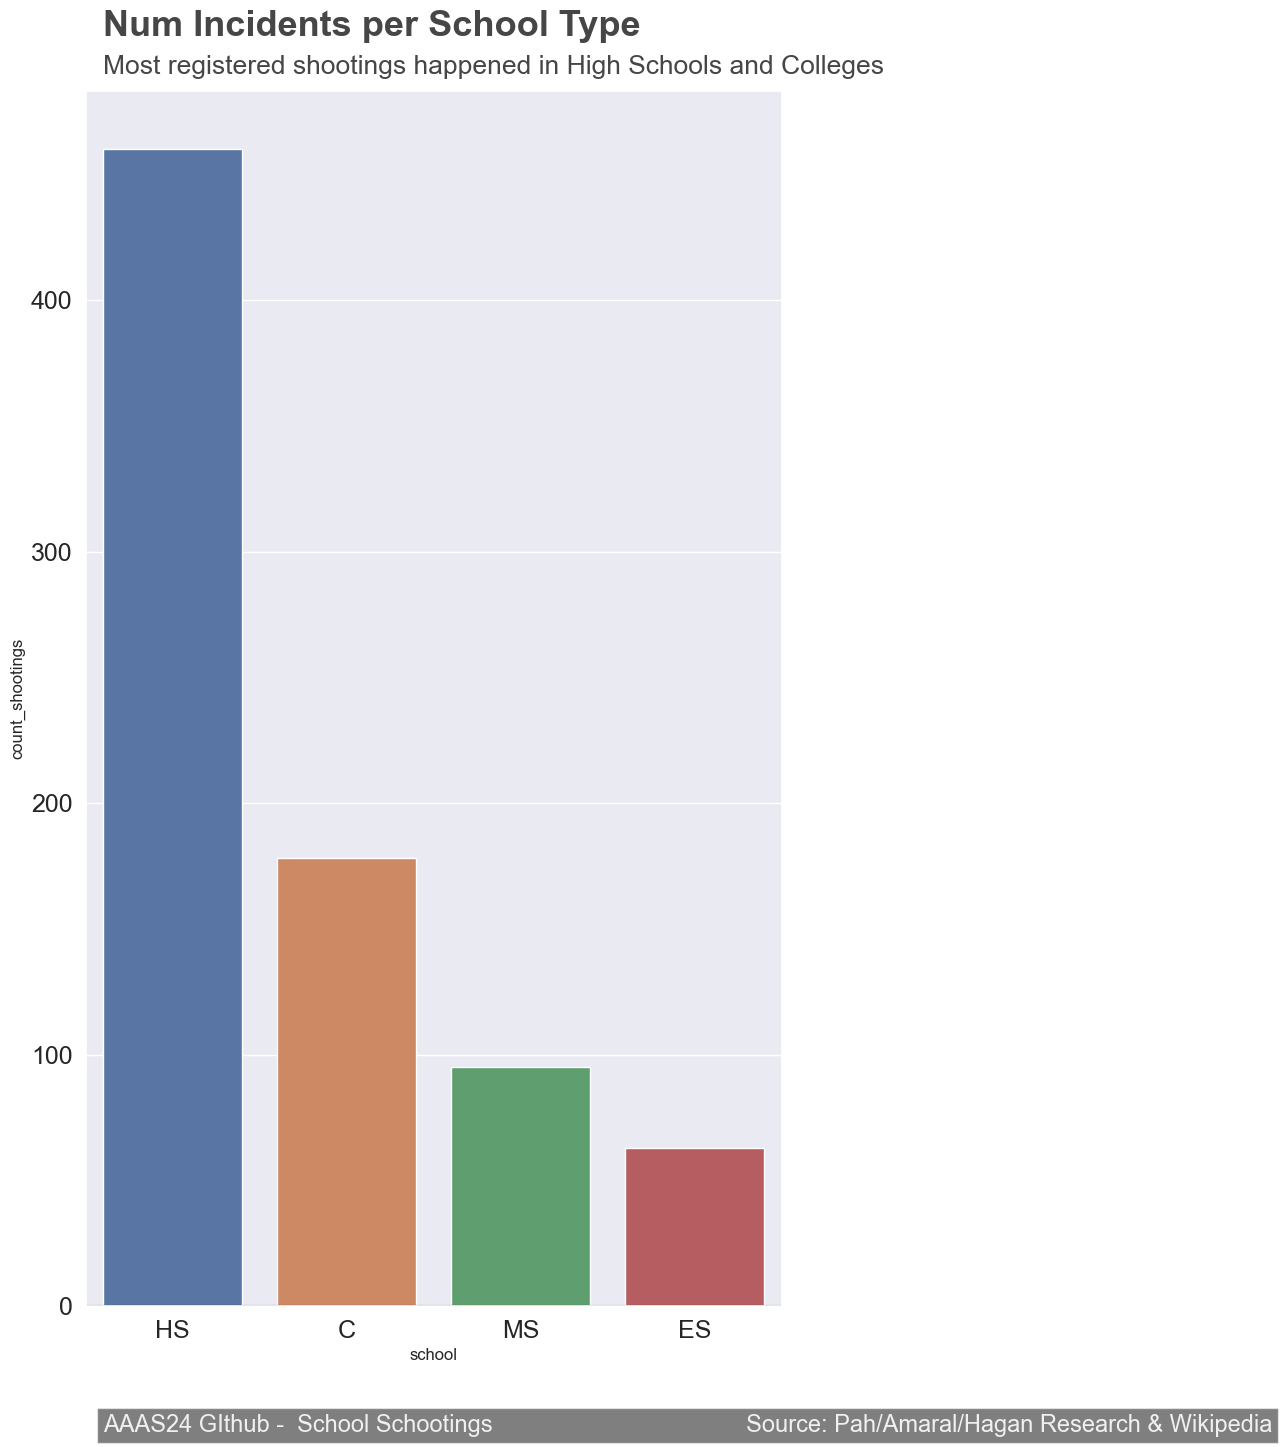

In [26]:
title='Num Incidents per School Type'
subtitle='Most registered shootings happened in High Schools and Colleges'
x_var='school'
y_var='count_shootings'

text_x=20


data=(
  df.copy()
  .groupby([x_var])
  .agg({'date': "count"} )
  .rename(columns={"date":"count_shootings"})
  .sort_values("count_shootings", ascending=False)
  .reset_index()
)
# data

sns.set(rc={"figure.figsize":(8 ,15)}) #(width,height)
sns.barplot(data=data, x=x_var, y=y_var)

#styling
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')


##title & subtitle
x=-0.4
plt.text(x=x, y=data[y_var].max()+45, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=data[y_var].max()+30, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##footer
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-50, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()

##Fatalities per Area Type

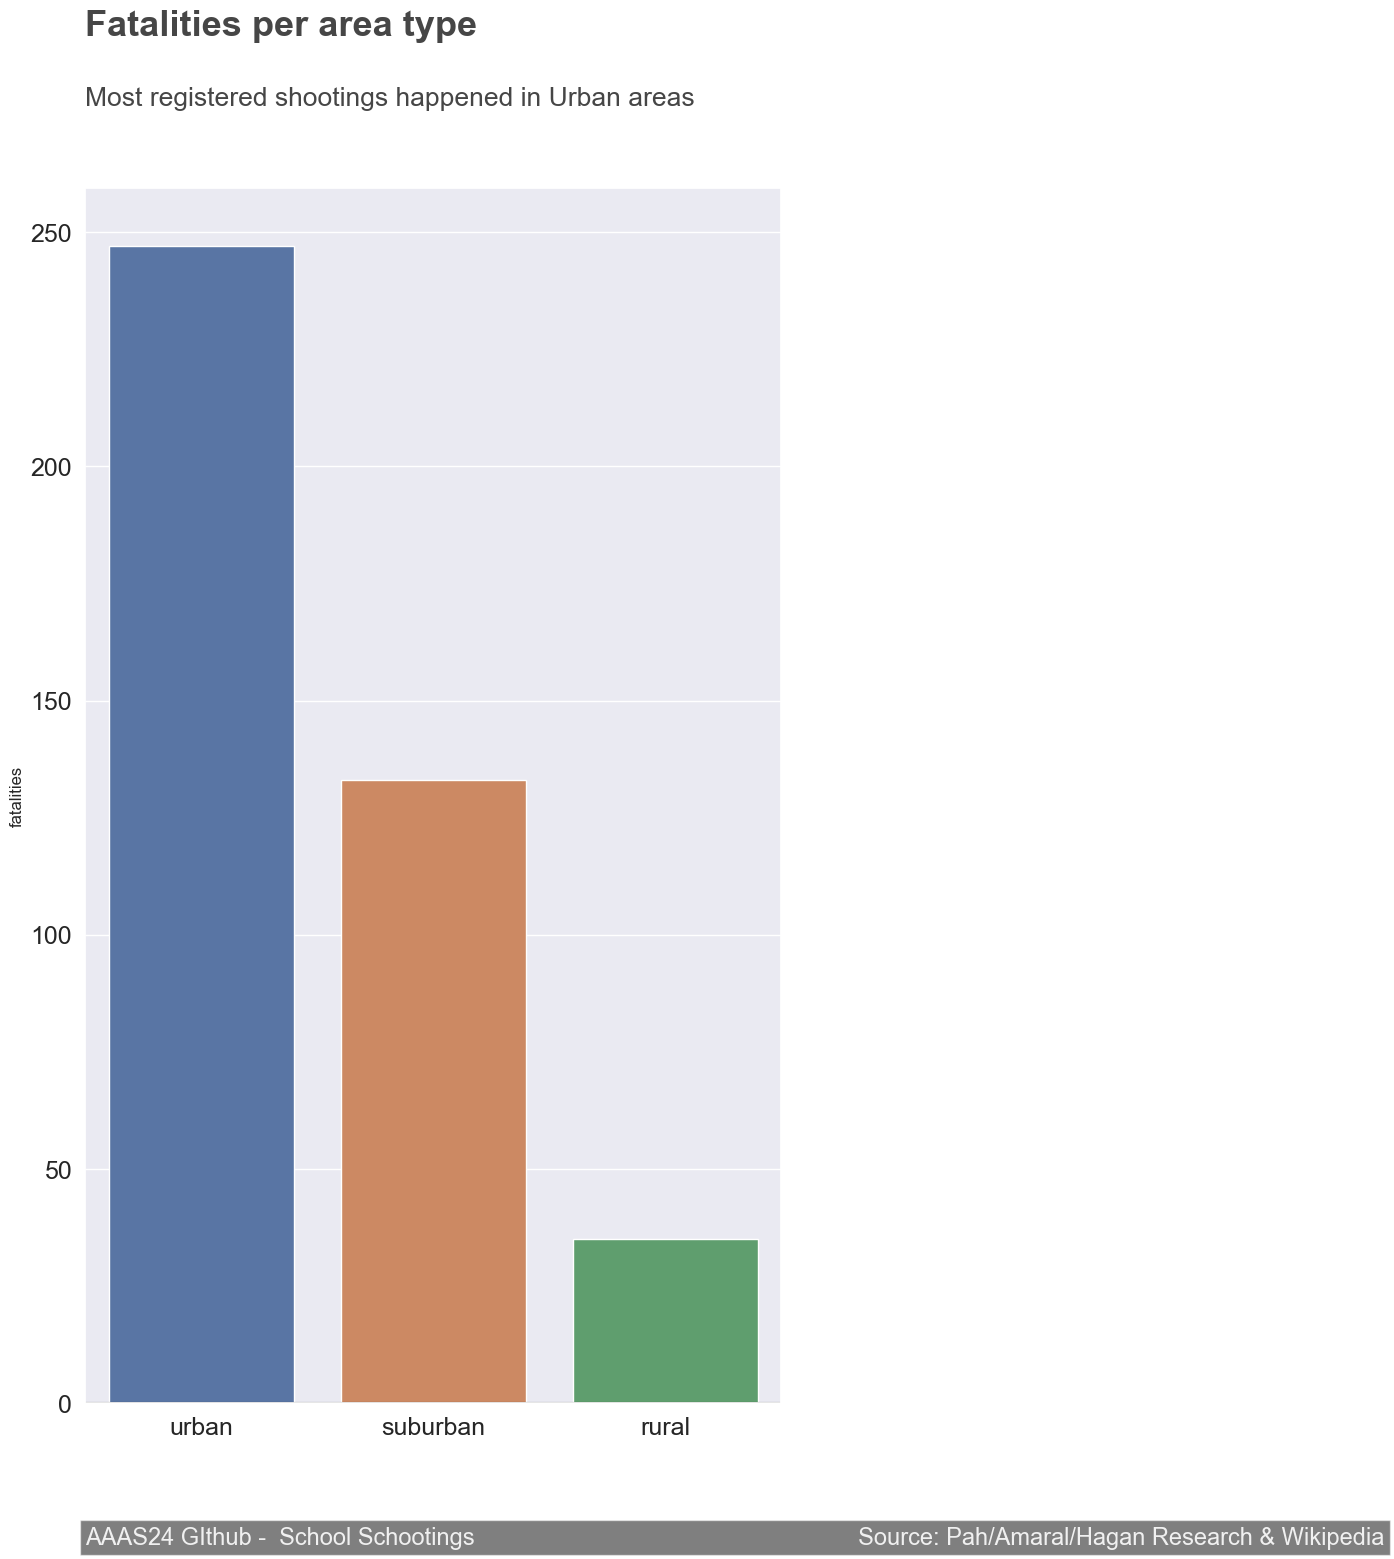

In [27]:
title='Fatalities per area type'
subtitle='Most registered shootings happened in Urban areas'
x_var='areatype'
y_var='fatalities'
text_x=30

data=(
    df.copy()
    .loc[:,[x_var,y_var]]
    .groupby([x_var]).sum()
    .sort_values(y_var, ascending=False)
    .reset_index()
)
data

ax=sns.barplot(data=data, x=x_var, y=y_var)
sns.set(rc={"figure.figsize":(8 ,15)}) #(width,height)

#styling
plt.tick_params(axis='both', which='major', labelsize=18)
plt.axhline(y=0, alpha=0.7, linewidth=1.5, color='black')

##hiding x label
ax.set(xlabel=None)



###Title & Subtitle
x=-0.5
plt.text(x=x, y=data[y_var].max()+45, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=data[y_var].max()+30, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##Footer #1
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-30, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()


##Top 10 states with highest sum of fatalities

In [28]:
data=(
    df.copy()
    .loc[:,['state', 'fatalities']]
    .groupby(['state']).sum()
    .sort_values('fatalities', ascending=False)
    [:10]
)
top_states=data.index.values.tolist()
top_states

['California',
 'Virginia',
 'Texas',
 'Connecticut',
 'Florida',
 'Colorado',
 'Pennsylvania',
 'Washington',
 'Tennessee',
 'Minnesota']

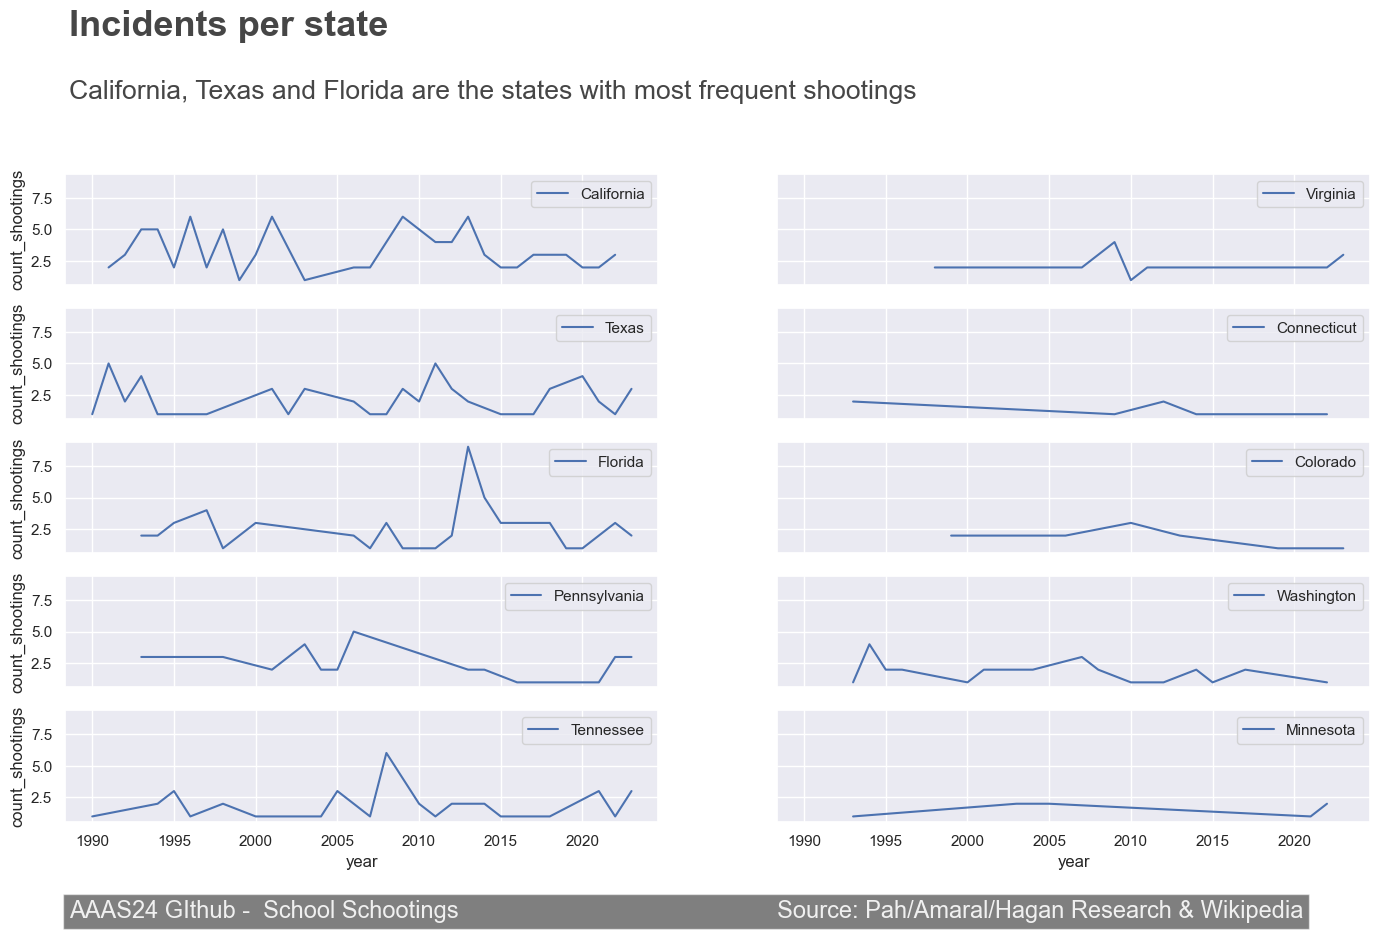

In [29]:
## Incidents per state
title='Incidents per state'
subtitle='California, Texas and Florida are the states with most frequent shootings'
text_x=25

data=(
    df.copy()
    [df.state.isin(top_states)]
    .loc[:,['year','state']]
    .groupby(['state', 'year'])
    .agg({'year': "count"} )
    .rename(columns={"year":"count_shootings"})
    .reset_index()
)
data
# grid
num_states=round(len(top_states))
cols=2
rows=int(np.ceil(num_states/cols))
fix, axes = plt.subplots(rows, cols, figsize=(15,8),sharex=True, sharey=True)
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(0, len(top_states)), 0):
  ax = axes[i]
  state_i=top_states[i]
  state_data=data[data.state==state_i].drop('state', axis=1)
  sns.lineplot(data=state_data, x='year', y='count_shootings', ax=ax, label=state_i)

###Title & Subtitle
x=+1945
y=(7.5*5)+(2*5)
plt.text(x=x, y=y+15, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=y+10, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##Footer #1
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-7, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()

## Fatalities per state (Top 10 states with highest)

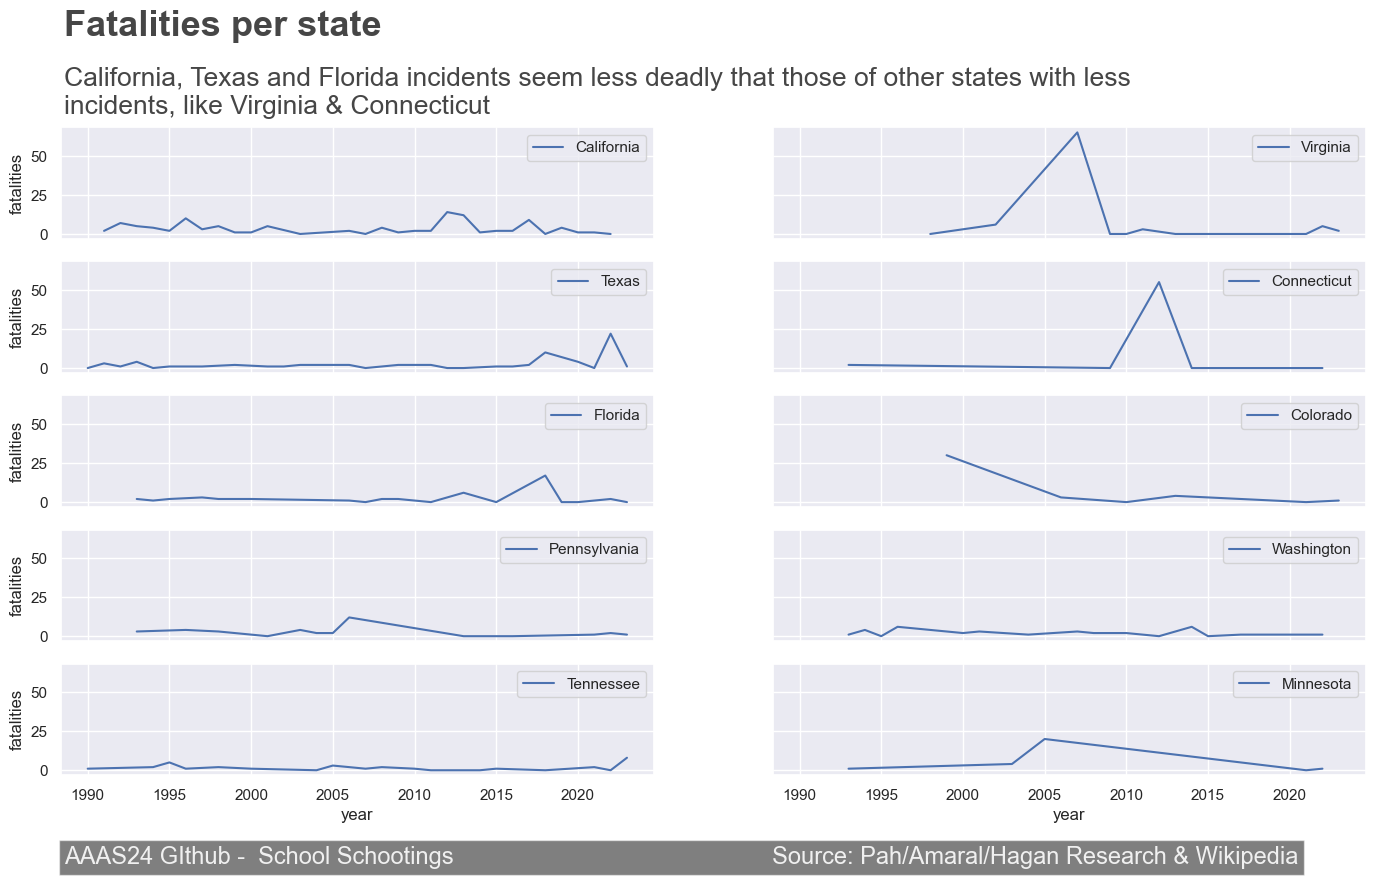

In [30]:
title='Fatalities per state'
subtitle='California, Texas and Florida incidents seem less deadly that those of other states with less \nincidents, like Virginia & Connecticut'
text_x=25

data=(
    df.copy()
    .loc[:,['year','state', 'fatalities']]
    [df.state.isin(top_states)]
    .groupby(['state','year']).sum()
    .reset_index()
)
# grid
num_states=round(len(top_states))
cols=2
rows=int(np.ceil(num_states/cols))
fix, axes = plt.subplots(rows, cols, figsize=(15,8),sharex=True, sharey=True)
axes = axes.reshape(cols * rows)
for i, k in enumerate(range(0, len(top_states)), 0):
  ax = axes[i]
  state_i=top_states[i]
  state_data=data[data.state==state_i].drop('state', axis=1)
  sns.lineplot(data=state_data, x='year', y='fatalities', ax=ax, label=state_i)
  plt.xlabel=(None)

###Title & Subtitle
x=+1945
y=(52*5)+(2*5)
plt.text(x=x, y=y+200, 
              s=title, 
              fontsize=26, weight='bold', alpha=.85
              )
plt.text(x=x, y=y+150, 
              s=subtitle, 
              fontsize=19, alpha=.85
              )

##Footer #1
num_spaces=" ".join(" "*int(text_x))
plt.text(x=x, y=-60, 
              s=footer_left+num_spaces+footer_right,
              fontsize=17, color="#f0f0f0",
              bbox=dict(facecolor="black", alpha=0.5)
              )
plt.show()



# ML: Word processing

In [31]:
## NPL to Desc:  Wordcloud of all data
# libraries for NLP
import nltk
nltk.download('omw-1.4')
from nltk import FreqDist
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    




[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alialvarez/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alialvarez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alialvarez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alialvarez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
#define original data
dirty = (
    df.copy()
    ['desc']
    .reset_index()
    .dropna()
)
dirty

,index,desc
0,0,A black youth was taunted with racial slurs by...
3,3,3 students were wounded when gunfire broke out...
5,5,15-year-old Raul Calvo shot himself dead while...
7,7,A teenager aimed and fired a handgun at a secu...
9,9,"17-year-old Arthur Jermel Jack, was killed by ..."
...,...,...
804,804,A 16-year-old Midwest City High School student...
805,805,A non-student was shot on the campus of North ...
806,806,Shooting of Zijie Yan: A graduate student shot...
807,807,Three people were shot at the St. Helena Colle...


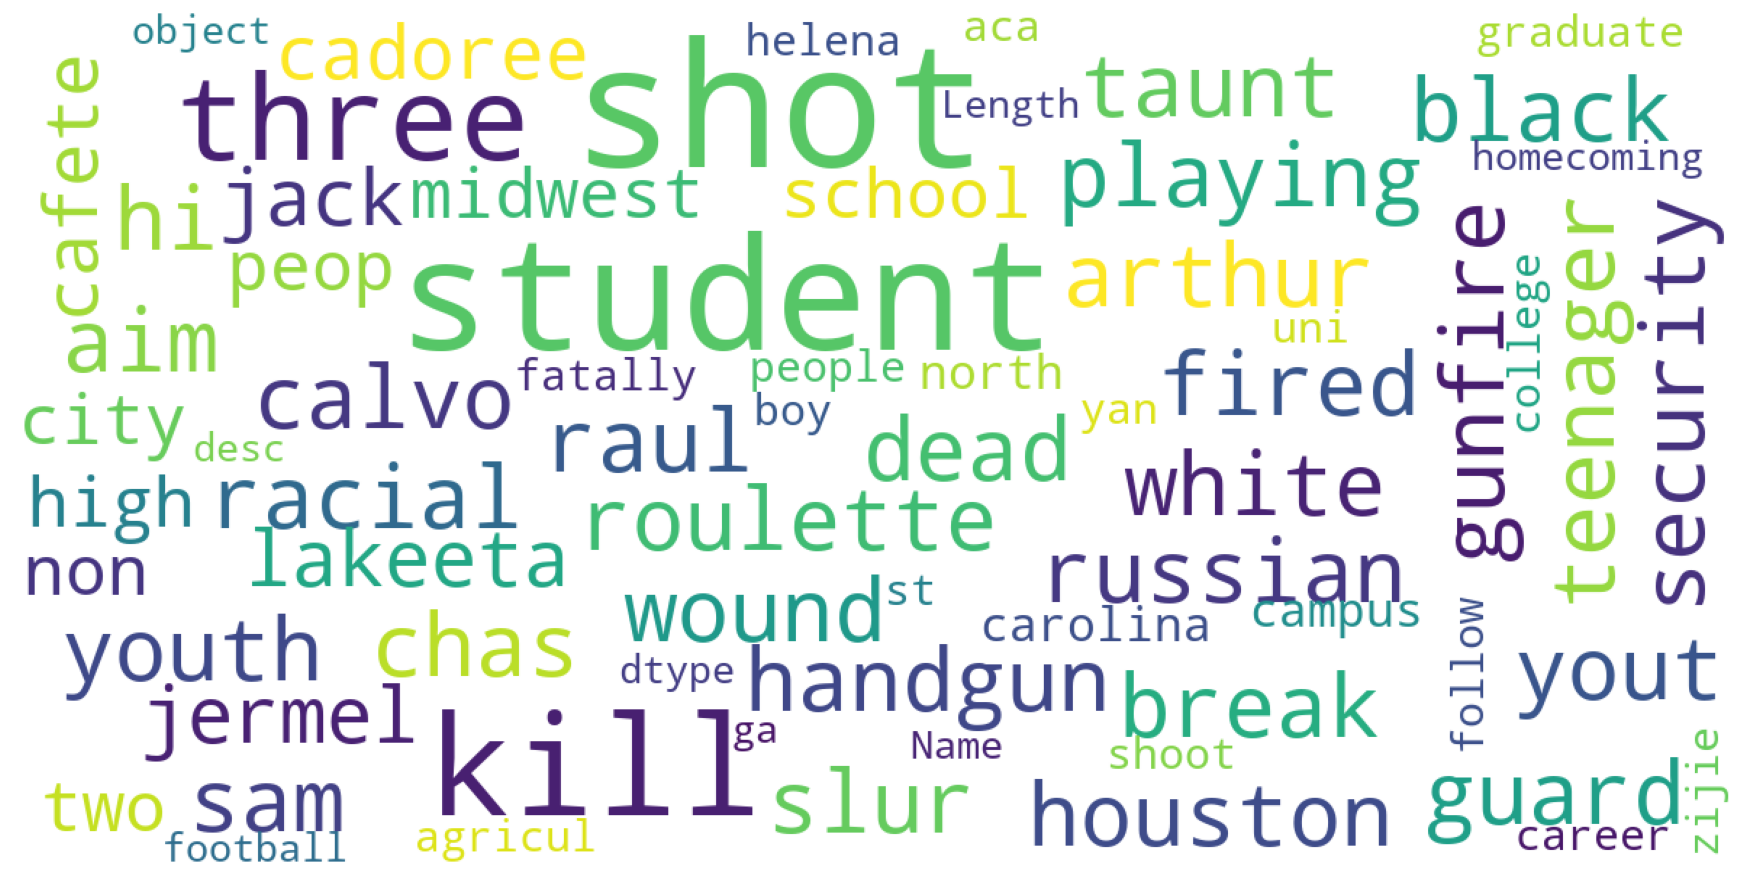

In [33]:
# clean text data

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

#define original data
dirty = (
    df.copy()
    ['desc']
    .reset_index()
    .dropna()
)

##clean data
content_clean=dirty.desc.apply(lambda x: clean_text(x))

##graphic wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
 
    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
 
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(content_clean)